In [180]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler

from open_clip import ClipLoss

In [181]:
with open('/home/docker_current/py_files/MLCLIP_exp/image_feat_array.npy', 'rb') as f:
    image_feat_array = np.load(f)

with open('/home/docker_current/py_files/MLCLIP_exp/text_feat_array.npy', 'rb') as f:
    text_feat_array = np.load(f)

X_train, X_test, y_train, y_test = train_test_split(text_feat_array, image_feat_array, 
                                                        test_size=0.25, random_state=42)

you_are_stupid = False

if you_are_stupid:
    X_train, y_train  = np.vstack((X_train, y_train)), np.vstack((y_train, X_train))
    print("you are stupid")

print(X_train.shape)

(1573, 768)


In [182]:
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.FloatTensor(X_train) 
y_train_t = torch.FloatTensor(y_train) 
X_val_t = torch.FloatTensor(X_test) 
y_val_t = torch.FloatTensor(y_test) 

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)

loaders = {"train": train_dataloader, "valid": val_dataloader}

In [183]:
class ImageEncoder(nn.Module):
    def __init__(self, ratio):
        super().__init__()
        self.ratio = ratio

        self.fc1 = nn.Linear(768, 1380)
        self.fc2 = nn.Linear(1380, 768)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = self.fc2(x)
        x = self.ratio * x + (1 - self.ratio) * input
        return x

class TextEncoder(nn.Module):
    def __init__(self, ratio):
        super().__init__()
        self.ratio = ratio
        
        self.fc1 = nn.Linear(768, 1380)
        self.fc2 = nn.Linear(1380, 768)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = self.fc2(x)
        x = self.ratio * x + (1 - self.ratio) * input
        return x

class MetaCLIP(nn.Module):
    def __init__(self, ratio=0.2):
        super().__init__()
        self.ratio = ratio
        self.encode_image = ImageEncoder(self.ratio)
        self.encode_text = TextEncoder(self.ratio)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        

    def forward(self, image, text):
        #open_clip realization
        image_features = self.encode_image(image)
        image_features = F.normalize(image_features, dim=-1)

        text_features = self.encode_text(text)
        text_features = F.normalize(text_features, dim=-1)

        return image_features, text_features, self.logit_scale.exp()

In [184]:
from torch.cuda.amp import GradScaler
from torch import optim
from metaclip_train import cosine_lr

class SampleData():
    def __init__(self, dataset, batch_size):
        self.dataloader = DataLoader(dataset, batch_size=batch_size)
        self.dataloader.num_samples = len(dataset)
        self.dataloader.num_batches = len(self.dataloader)

class Args:
    device = 'cuda:0'
    precision = 'amp'
    local_loss = False
    gather_with_grad = False
    rank = 0
    world_size = 1
    horovod = False
    norm_gradient_clip = None
    batch_size = 64
    wandb = False
    val_frequency = 5
    save_logs = False
    epochs = 200
    lr = 0.35e-4

args = Args()

data = {}
data['train'] = SampleData(train_dataset, args.batch_size)
data['val'] = SampleData(val_dataset, args.batch_size)

model = MetaCLIP(ratio=0.5)
model.to(args.device)

optimizer = optim.AdamW(model.parameters(), lr=args.lr)
scaler = GradScaler() if args.precision == "amp" else None

total_steps = data["train"].dataloader.num_batches * args.epochs
scheduler = cosine_lr(optimizer, args.lr, 15, total_steps)

writer = None

In [185]:
model, model.ratio

(MetaCLIP(
   (encode_image): ImageEncoder(
     (fc1): Linear(in_features=768, out_features=1380, bias=True)
     (fc2): Linear(in_features=1380, out_features=768, bias=True)
   )
   (encode_text): TextEncoder(
     (fc1): Linear(in_features=768, out_features=1380, bias=True)
     (fc2): Linear(in_features=1380, out_features=768, bias=True)
   )
 ),
 0.5)

In [186]:
# from tqdm.notebook import tqdm

from metaclip_train import train_one_epoch, evaluate

start_epoch = 0
completed_epoch = 0

best_val_loss = 1e6
val_losses = []

for epoch in range(start_epoch, args.epochs):
    # if is_master(args):
    # logging.info(f'Start epoch {epoch}')

    train_one_epoch(model, data, epoch, optimizer, scaler, scheduler, args, writer)
    val_loss = evaluate(model, data, completed_epoch, args, writer)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './weights/metaclip_v5_ratio_05.pth')
        print("epoch ", epoch, "model loaded with best loss ", best_val_loss)
    
    completed_epoch = epoch + 1

epoch  0 model loaded with best loss  tensor(2.0488, device='cuda:0')
epoch  1 model loaded with best loss  tensor(1.6960, device='cuda:0')
epoch  2 model loaded with best loss  tensor(1.4539, device='cuda:0')
epoch  3 model loaded with best loss  tensor(1.2996, device='cuda:0')
epoch  4 model loaded with best loss  tensor(1.1953, device='cuda:0')
epoch  5 model loaded with best loss  tensor(1.1164, device='cuda:0')
epoch  6 model loaded with best loss  tensor(1.0541, device='cuda:0')
epoch  7 model loaded with best loss  tensor(1.0038, device='cuda:0')
epoch  8 model loaded with best loss  tensor(0.9623, device='cuda:0')
epoch  9 model loaded with best loss  tensor(0.9277, device='cuda:0')
epoch  10 model loaded with best loss  tensor(0.8983, device='cuda:0')
epoch  11 model loaded with best loss  tensor(0.8730, device='cuda:0')
epoch  12 model loaded with best loss  tensor(0.8509, device='cuda:0')
epoch  13 model loaded with best loss  tensor(0.8314, device='cuda:0')
epoch  14 model 

0.6953872442245483


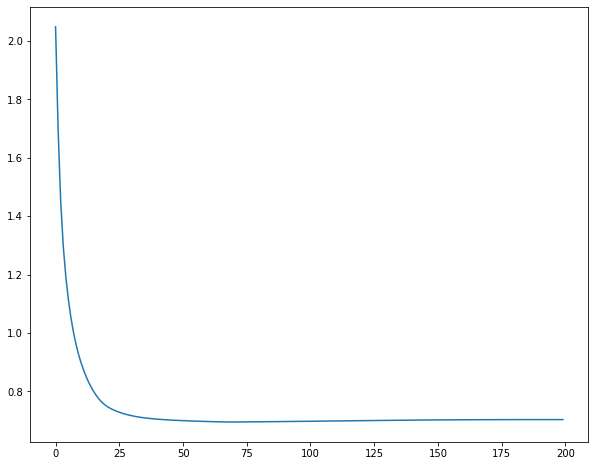

In [187]:
import matplotlib.pyplot as plt
val_losses = [i.tolist() for i in val_losses]
plt.figure(figsize=(10, 8))
plt.plot(val_losses)
print(min(val_losses))

In [188]:
val_losses[np.argmin(np.array(val_losses))], np.argmin(np.array(val_losses))

(0.6953872442245483, 70)